# Frequency Doubling with Adaptive Filters

Ian Malone

This problem can be called frequency doubling, because we want to learn the mapping that doubles the frequency of a single sine wave with an adaptive filter. Take the input at 1KHz sampled at 10KHz, and the desired response at 2KHz, and generate 2 seconds of data. 


Part 1) 
Use a linear FIR filter of size 10 trained with Wiener solution and LMS. Verify if the Wiener filter is able to solve this problem. Explain what happens in your own words. 


Part 2) 
Apply the KLMS to this problem (also using a vector of 10 input samples) and show that the solution is quite good. Experiment with different kernel sizes and also stepsizes to find the best performance. With the same parameters (i.e. no adaptation), change the input frequency between 500 Hz to 2KHz and show experimentally the generalization of the trained model. 


Part 3) 
Now repeat 2 with noise. Create a r.v. u obtained from a Gaussian mixture 𝑝(𝑢) = 0.9𝐺(0,0.1) + 0.1𝐺(4,0.1) and add the noise to the desired response. Quantify the effect of the noise in the model trained with MSE. Now implement the correntropy criterion (MCC) and compare the performance with the MSE. You have to properly determine the kernel size in MCC for optimal results. So
show the effect of the kernel size in performance as a function the kernel size in the MCC cost. You can also experiment to test generalization as in 2. 

## Implementation

## *Note: QKLMS does not seem to be working. While it can approximate a sinusoidal shape, my implementation can not approximate the amplitude of the desired signal. My model's output always has very low amplitude.*

#### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import linalg
from statsmodels.tsa.stattools import acf,ccf
%load_ext autotime

time: 0 ns (started: 2021-03-30 21:26:59 -04:00)


#### Make filter classes

In [2]:
class Wiener():
    def __init__(self, order, start, length):
        self.order = order
        self.start = start
        self.length = length
        
    def learn(self, input_signal, desired_signal):
        '''Find optimal filter weights using Wiener filter given and input and output signal'''        
        desired_signal = np.matrix(desired_signal).T
        input_signal = np.matrix(input_signal).T
        
        A = np.matrix(np.zeros((self.length,self.order)))
        
        for i in range(self.length):
            A[i,:] = input_signal[i+np.arange(self.order)].T # self.order or self.order-1 ???

        R = A.T*A
        P = A.T*desired_signal[self.start:self.length+self.start]
        w_opt = np.linalg.inv(R)*P
        
        return w_opt
        

        
class LMS():
    
    def __init__(self, step_size, order):
        self.step_size = step_size
        self.order = order
        
    def learn(self, u, d):

        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))

        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            w = w + (self.step_size * e[i] * u[i])
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e  
    
    
    
class NLMS():
    
    def __init__(self, step_size, order):
        self.step_size = step_size
        self.order = order
        
    def learn(self, u, d):

        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))

        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            norm = ((np.linalg.norm(u[i:i+self.order])) ** 2)+0.1
            w = w + (self.step_size * e[i] * u[i])/norm   #normalize the step by the power of the input
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e

    
    
class GaussianKernel:
    def kernel(self, a, b):
        numer = (np.linalg.norm(a - b)) ** 2
        denom = (2 * self.sigma ** 2)
        return np.exp(-1 * (numer / denom))
    
    
    
class KLMS(GaussianKernel):
    
    def __init__(self, step_size, sigma, order): 
        self.step_size = step_size
        self.sigma = sigma
        self.order = order
    
    def learn(self, input_signal, desired_signal):
        estimates = np.zeros(len(input_signal))
        coefficients = np.zeros(len(input_signal))
        errors = np.zeros(len(input_signal))
        coefficients[0] = self.step_size * desired_signal[0]

        for i in range(1, len(input_signal)-self.order):
            for j in range(i-1):
                
                partial_sum = coefficients[j] * self.kernel(input_signal[i:i+(self.order)], input_signal[j:j+(self.order)])
                estimates[i] += partial_sum                 

            errors[i] = desired_signal[i+self.order] - estimates[i]
            coefficients[i] = self.step_size * errors[i]
        
        return estimates, coefficients, errors
    
    
    
class QKLMS(GaussianKernel):
    
    def __init__(self, step_size, sigma, order, epsilon):
        self.step_size = step_size
        self.sigma = sigma
        self.order = order
        self.epsilon = epsilon
        
    def learn(self, input_signal, desired_signal):
        estimates = np.zeros(len(input_signal))
        errors = np.zeros(len(input_signal))
        coefficients = np.zeros(len(input_signal))
        coefficients[0] = self.step_size * desired_signal[0]
            
        center_vectors = np.empty([0, self.order]) ## HIGHTLIGHT
        center_vectors = np.vstack((center_vectors, input_signal[:self.order]))
        
        distance = []
        size = np.asarray(np.zeros(len(input_signal))) # these keeps track of the network size over iterations
        size[0]=1
        

        for i in range(len(input_signal)-self.order):
            for j in range(center_vectors.shape[0]):  ### HIGHTLIGHT AND LINE BELOW
                partial_sum = coefficients[j] * self.kernel(input_signal[i:i+(self.order)], center_vectors[j])
                estimates[i] += partial_sum                 
                distance.append(np.linalg.norm(np.asarray(input_signal[i:i+(self.order)]) - np.asarray(center_vectors[j])))
            
            errors[i] = desired_signal[i] - estimates[i]  #should it really be desired_signal[i+self.order]
            
            if distance != []: # this probably shouldnt even be necesssary
                dist = np.min(distance)
                loc = np.argmin(distance)

                if dist <= self.epsilon:
                    coefficients[i] = coefficients[loc] + self.step_size * errors[i]
                    size = np.append(size, size[-1])
                    #size.append[size[-1]]
                else:
                    center_vectors = np.vstack((center_vectors, input_signal[i:i+(self.order)]))  ## HIGHTLIGHT np.vstack
                    size = np.append(size, size[-1]+1)
                    coefficients[i] = coefficients[i-1] + self.step_size * errors[i] 
                    #size.append[size[-1]+1]
                
            distance = []

        return estimates, coefficients, errors, size
    
    

class MCC_QKLMS(GaussianKernel):
    
    def __init__(self, step_size, sigma, order, epsilon):
        self.step_size = step_size
        self.sigma = sigma
        self.order = order
        self.epsilon = epsilon
        
    def learn(self, input_signal, desired_signal):
        estimates = np.zeros(len(input_signal))
        errors = np.zeros(len(input_signal))
        coefficients = np.zeros(len(input_signal))
        coefficients[0] = self.step_size * desired_signal[0]
            
        center_vectors = np.empty([0, self.order]) ## HIGHTLIGHT
        center_vectors = np.vstack((center_vectors, input_signal[:self.order]))
        
        distance = []
        size = np.asarray(np.zeros(len(input_signal))) # these keeps track of the network size over iterations
        size[0]=1
        

        for i in range(len(input_signal)-self.order):
            for j in range(center_vectors.shape[0]):  ### HIGHTLIGHT AND LINE BELOW
                partial_sum = coefficients[j] * self.kernel(input_signal[i:i+(self.order)], center_vectors[j])
                estimates[i] += partial_sum                 
                distance.append(np.linalg.norm(np.asarray(input_signal[i:i+(self.order)]) - np.asarray(center_vectors[j])))
            
            errors[i] = desired_signal[i] - estimates[i]  #should it really be desired_signal[i+self.order]
            
            if distance != []: # this probably shouldnt even be necesssary
                dist = np.min(distance)
                loc = np.argmin(distance)

                if dist <= self.epsilon:
                    coefficients[i] = coefficients[loc] + self.step_size * errors[i] * input_signal[i]
                    size = np.append(size, size[-1])
                    #size.append[size[-1]]
                else:
                    center_vectors = np.vstack((center_vectors, input_signal[i:i+(self.order)]))  ## HIGHTLIGHT np.vstack
                    size = np.append(size, size[-1]+1)
                    coefficients[i] = self.step_size * errors[i] * input_signal[i]  # coefficients[i-1] + 
                    #size.append[size[-1]+1]
                
            distance = []

        return estimates, coefficients, errors, size

time: 0 ns (started: 2021-03-30 21:26:59 -04:00)


#### Define functions you may need

In [3]:
def ensemble_learning_curve(errors_matrix):
    # ensemble of adaptive filters with same configuration settings
    # get MSE vector for each filter
    # average MSE across filters
    errors = errors_matrix.mean(0)
    curve = []
    for i in range(len(errors)):
        curve.append(np.mean(errors[:i]**2))
    return curve

def freq_response(e, d, fs):
    return rfftfreq(len(e), 1/fs), abs(scipy.fft.rfft(e)/scipy.fft.rfft(d))

def gaussian_kernel(a, b, sigma):
    numer = (np.linalg.norm(a - b)) ** 2
    denom = (2 * sigma ** 2)
    return np.exp(-1 * (numer / denom))

def ERLE(d, e):
    return float(10*np.log10(sum(d**2)/sum(e**2)))

def iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    return q75 - q25

def learning_curve(errors):
    curve = []
    for i in range(len(errors)):
        curve.append(np.mean(errors[:i]**2))
    return curve

def klms_misadjustment(u, step_size, sigma):
    # klms: p38 text..  
    # data independent with shift-invariant kernels
    # with Gaussian kernel, this evaluates to 0.5*step_size
    kern = []
    for i in u:
        kern.append(gaussian_kernel(i, i, sigma))
    return step_size*0.5*(1/(len(u)))*np.sum(kern)

def klms_step(u, sigma):
    # p38 text
    kern = []
    for i in u:
        kern.append(gaussian_kernel(i, i, sigma))
    return len(u)/np.sum(kern)

def mse(errors):
    return np.mean(errors**2)

def nlms_misadjustment(u, step_size):
    # nlms: p30 text.. 
    # 0.5*step_size*tr[R] = 0.5*step_size*mean*square
    return 0.5*step_size*np.mean(u**2)

def nlms_step(u):
    # p30 textbook
    return 1/(np.mean(u**2))

def silverman_bandwidth(x):
    return 1.06*np.min([np.std(x),iqr(x)/1.34])*(len(x)**(-1/5))

time: 0 ns (started: 2021-03-30 21:26:59 -04:00)


#### Create signals

In [4]:
fs = 10000
time = np.arange(0, 2, 1/fs)

# generate input signal (2 second sine wave, 1 kHz frequency, 10 kHz sampling)
f_in = 1000
w_in = 2. * np.pi * f_in
sine_1k = np.sin(w_in * time)

# generate desired signal (2 second sine wave, 2 kHz frequency, 10 kHz sampling)
f_des = 2000
w_des = 2. * np.pi * f_des
sine_2k = np.sin(w_des * time)

time: 15 ms (started: 2021-03-30 21:26:59 -04:00)


Part 1) 
Use a linear FIR filter of size 10 trained with Wiener solution and LMS. Verify if the Wiener filter is able to solve this problem. Explain what happens in your own words. 

#### Wiener FIR Solution

In [5]:
wiener_part1 = Wiener(order=10, start=10, length=10000)
wopt_part1 = wiener_part1.learn(sine_1k, sine_2k)
wopt_part1 = np.asarray(wopt_part1).flatten()

time: 94 ms (started: 2021-03-30 21:26:59 -04:00)


In [6]:
wiener_result_part1 = np.convolve(sine_1k, wopt_part1)

time: 0 ns (started: 2021-03-30 21:26:59 -04:00)


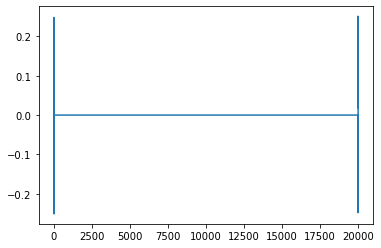

time: 94 ms (started: 2021-03-30 21:26:59 -04:00)


In [7]:
plt.plot(wiener_result_part1)

### The Wiener filter is unable to solve this problem, likely due to the nonlinear nature of the task.

#### LMS FIR Solution

In [8]:
lms_part1 = LMS(step_size=0.1, order=10)
outputs_lms_part1, w_trk_lms_part1, error_lms_part1 = lms_part1.learn(sine_1k, sine_2k)

time: 78 ms (started: 2021-03-30 21:27:00 -04:00)


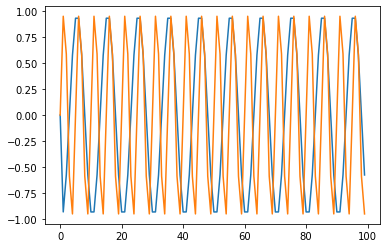

time: 94 ms (started: 2021-03-30 21:27:00 -04:00)


In [9]:
plt.plot(outputs_lms_part1[:100])
plt.plot(sine_2k[:100])

### The LMS filter solves the problem better than the Wiener filter can; however, its performance is not ideal.

Part 2) 
Apply the KLMS to this problem (also using a vector of 10 input samples) and show that the solution is quite good. Experiment with different kernel sizes and also stepsizes to find the best performance. With the same parameters (i.e. no adaptation), change the input frequency between 500 Hz to 2KHz and show experimentally the generalization of the trained model. 

#### Find a good sigma

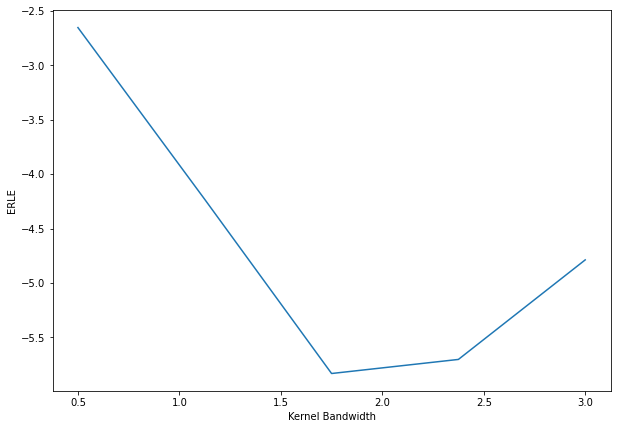

time: 10.5 s (started: 2021-03-30 21:27:00 -04:00)


In [10]:
reps = 1
sigmas = np.linspace(0.5, 3, num=5)
ERLEs = np.zeros((reps, len(sigmas)))

for i in range(reps):
    for j in range(len(sigmas)):
        qklms_part1 = QKLMS(step_size=1, sigma=sigmas[j], order=10, epsilon=1.5)
        outputs_qklms_part1, coefficients_qklms_part1, errors_qklms_part1, size_qklms_part1 = qklms_part1.learn(sine_1k, sine_2k)
        ERLEs[i,j] = ERLE(sine_2k, errors_qklms_part1)

sigma = sigmas[np.argmax(ERLEs.mean(axis=0))]


plt.figure(figsize=(10,7))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 1}
plt.xlabel('Kernel Bandwidth')
plt.ylabel('ERLE')
plt.plot(sigmas,ERLEs.mean(axis=0))

#### Find a good step size

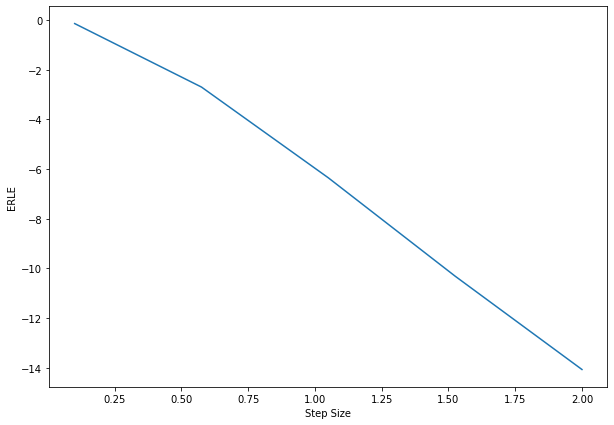

time: 10.2 s (started: 2021-03-30 21:27:10 -04:00)


In [11]:
reps = 1
steps = np.linspace(0.1, 2, num=5)
ERLEs = np.zeros((reps, len(sigmas)))

for i in range(reps):
    for j in range(len(sigmas)):
        qklms_part1 = QKLMS(step_size=steps[j], sigma=2, order=10, epsilon=1.5)
        outputs_qklms_part1, coefficients_qklms_part1, errors_qklms_part1, size_qklms_part1 = qklms_part1.learn(sine_1k, sine_2k)
        ERLEs[i,j] = ERLE(sine_2k, errors_qklms_part1)

step = steps[np.argmax(ERLEs.mean(axis=0))]


plt.figure(figsize=(10,7))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 1}
plt.xlabel('Step Size')
plt.ylabel('ERLE')
plt.plot(steps,ERLEs.mean(axis=0))

#### Find a good epsilon

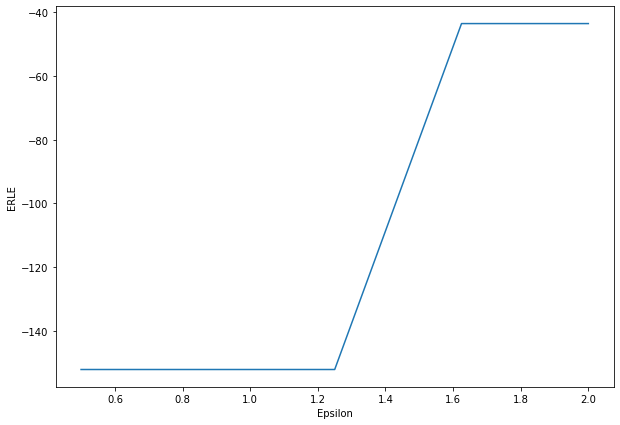

time: 14.7 s (started: 2021-03-30 21:27:21 -04:00)


In [12]:
reps = 1
epsilons = np.linspace(0.5, 2, num=5)
ERLEs = np.zeros((reps, len(sigmas)))

for i in range(reps):
    for j in range(len(sigmas)):
        qklms_part1 = QKLMS(step_size=11, sigma=2, order=10, epsilon=epsilons[j])
        outputs_qklms_part1, coefficients_qklms_part1, errors_qklms_part1, size_qklms_part1 = qklms_part1.learn(sine_1k, sine_2k)
        ERLEs[i,j] = ERLE(sine_2k, errors_qklms_part1)

epsilon = epsilons[np.argmax(ERLEs.mean(axis=0))]


plt.figure(figsize=(10,7))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 1}
plt.xlabel('Epsilon')
plt.ylabel('ERLE')
plt.plot(epsilons,ERLEs.mean(axis=0))

In [13]:
qklms_part1 = QKLMS(step_size=step, sigma=sigma, order=10, epsilon=epsilon)
outputs_qklms_part1, coefficients_qklms_part1, errors_qklms_part1, size_qklms_part1 = qklms_part1.learn(sine_1k, sine_2k)

time: 2.03 s (started: 2021-03-30 21:27:35 -04:00)


C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


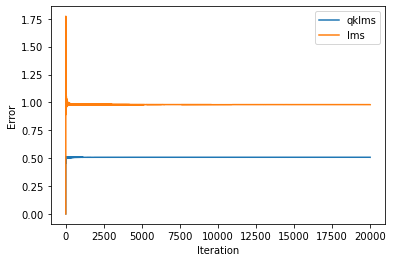

time: 594 ms (started: 2021-03-30 21:27:37 -04:00)


In [14]:
plt.plot(learning_curve(errors_qklms_part1), label='qklms')
plt.plot(learning_curve(error_lms_part1), label='lms')
plt.xlabel('Iteration')
plt.ylabel('Error')

plt.legend(loc='upper right')

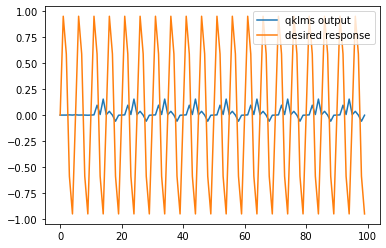

time: 125 ms (started: 2021-03-30 21:27:38 -04:00)


In [15]:
plt.plot(outputs_qklms_part1[:100], label='qklms output')
plt.plot(sine_2k[:100], label='desired response')
plt.legend(loc='upper right')

#### Generalize from 500 Hz to 2000 Hz

In [16]:
# make 500 Hz and 2000 Hz sine waves
f_500 = 500
w_500 = 2. * np.pi * f_500
sine_500 = np.sin(w_500 * time)

f_1500 = 1500
w_1500 = 2. * np.pi * f_1500
sine_1500 = np.sin(w_1500 * time)

time: 0 ns (started: 2021-03-30 21:27:38 -04:00)


In [17]:
qklms_part1 = QKLMS(step_size=step, sigma=sigma, order=10, epsilon=epsilon)
outputs_qklms_part1_500, coefficients_qklms_part1_500, errors_qklms_part1_500, size_qklms_part1_500 = qklms_part1.learn(sine_500, sine_2k)

time: 2.34 s (started: 2021-03-30 21:27:38 -04:00)


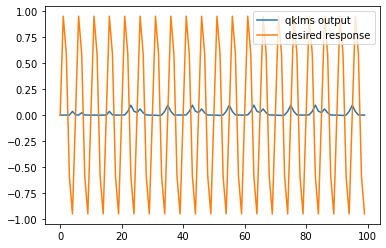

time: 156 ms (started: 2021-03-30 21:27:40 -04:00)


In [18]:
plt.plot(outputs_qklms_part1_500[:100], label='qklms output')
plt.plot(sine_2k[:100], label='desired response')
plt.legend(loc='upper right')

In [19]:
qklms_part1 = QKLMS(step_size=step, sigma=sigma, order=10, epsilon=epsilon)
outputs_qklms_part1_1500, coefficients_qklms_part1_1500, errors_qklms_part1_1500, size_qklms_part1_1500 = qklms_part1.learn(sine_1500, sine_2k)

time: 2.34 s (started: 2021-03-30 21:27:41 -04:00)


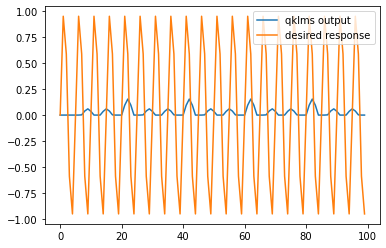

time: 125 ms (started: 2021-03-30 21:27:43 -04:00)


In [20]:
plt.plot(outputs_qklms_part1_1500[:100], label='qklms output')
plt.plot(sine_2k[:100], label='desired response')
plt.legend(loc='upper right')

C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


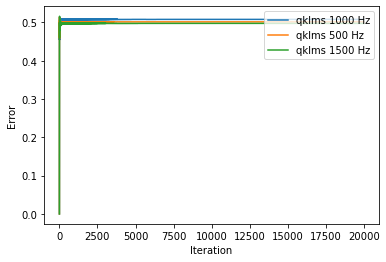

time: 813 ms (started: 2021-03-30 21:27:43 -04:00)


In [21]:
plt.plot(learning_curve(errors_qklms_part1), label='qklms 1000 Hz')
plt.plot(learning_curve(errors_qklms_part1_500), label='qklms 500 Hz')
plt.plot(learning_curve(errors_qklms_part1_1500), label='qklms 1500 Hz')

plt.xlabel('Iteration')
plt.ylabel('Error')

plt.legend(loc='upper right')

### The trained model does not seem to lose performance when generalizing as shown above. The error is lower when the frequency of the input signal is closer to the frequency of the desired signal.

Part 3) 
Now repeat 2 with noise. Create a r.v. u obtained from a Gaussian mixture 𝑝(𝑢) = 0.9𝐺(0,0.1) + 0.1𝐺(4,0.1) and add the noise to the desired response. Quantify the effect of the noise in the model trained with MSE. Now implement the correntropy criterion (MCC) and compare the performance with the MSE. You have to properly determine the kernel size in MCC for optimal results. So
show the effect of the kernel size in performance as a function the kernel size in the MCC cost. You can also experiment to test generalization as in 2. 

#### Add noise to desired response

In [22]:
noise = 0.9*np.random.normal(0, 0.1) + 0.1*np.random.normal(4, 0.1)
noisy_sine_2k = sine_2k + noise

time: 0 ns (started: 2021-03-30 21:27:44 -04:00)


#### Apply QKLMS to noisy sine

In [23]:
qklms_part1 = QKLMS(step_size=step, sigma=sigma, order=10, epsilon=epsilon)
outputs_qklms_noisy_sine, coefficients_qklms_noisy_sine, errors_qklms_noisy_sine, size_qklms_noisy_sine = qklms_part1.learn(sine_1k, noisy_sine_2k)

time: 2.03 s (started: 2021-03-30 21:27:44 -04:00)


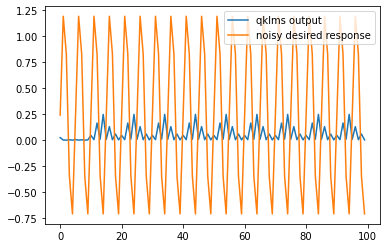

time: 109 ms (started: 2021-03-30 21:27:46 -04:00)


In [24]:
plt.plot(outputs_qklms_noisy_sine[:100], label='qklms output')
plt.plot(noisy_sine_2k[:100], label='noisy desired response')
plt.legend(loc='upper right')

In [25]:
mse(errors_qklms_noisy_sine)

0.5464838871380314

time: 0 ns (started: 2021-03-30 21:27:46 -04:00)


#### Implement with MCC

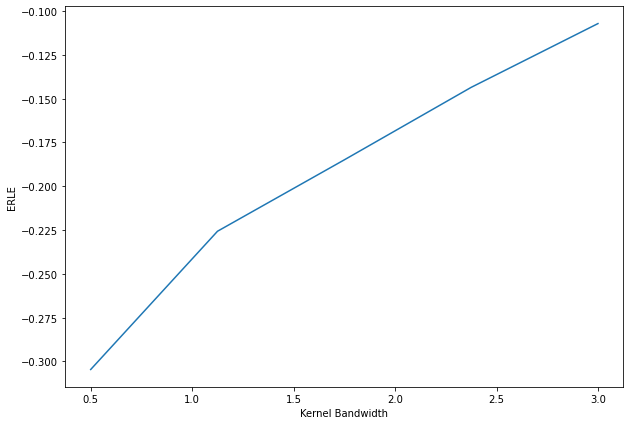

time: 10.3 s (started: 2021-03-30 21:27:46 -04:00)


In [26]:
# find good kernel size for MCC

reps = 1
sigmas = np.linspace(0.5, 3, num=5)
ERLEs = np.zeros((reps, len(sigmas)))

for i in range(reps):
    for j in range(len(sigmas)):
        qklms_mcc = MCC_QKLMS(step_size=step, sigma=sigmas[j], order=10, epsilon=epsilon)
        outputs_mcc, coefficients_mcc, errors_mcc, size_mcc = qklms_mcc.learn(sine_1k, noisy_sine_2k)
        ERLEs[i,j] = ERLE(sine_2k, errors_mcc)

sigma = sigmas[np.argmax(ERLEs.mean(axis=0))]


plt.figure(figsize=(10,7))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 1}
plt.xlabel('Kernel Bandwidth')
plt.ylabel('ERLE')
plt.plot(sigmas,ERLEs.mean(axis=0))

In [27]:
qklms_mcc = MCC_QKLMS(step_size=step, sigma=sigma, order=10, epsilon=epsilon)
outputs_mcc, coefficients_mcc, errors_mcc, size_mcc = qklms_mcc.learn(sine_1k, noisy_sine_2k)

time: 2.05 s (started: 2021-03-30 21:27:56 -04:00)


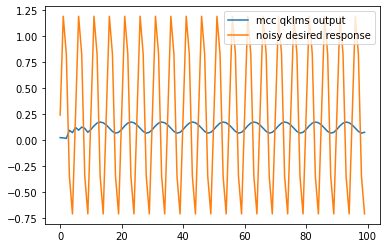

time: 125 ms (started: 2021-03-30 21:27:58 -04:00)


In [28]:
plt.plot(outputs_mcc[:100], label='mcc qklms output')
plt.plot(noisy_sine_2k[:100], label='noisy desired response')
plt.legend(loc='upper right')

#### How does the model generalize?

In [29]:
qklms_mcc = MCC_QKLMS(step_size=step, sigma=sigma, order=10, epsilon=epsilon)
outputs_mcc, coefficients_mcc, errors_mcc, size_mcc = qklms_mcc.learn(sine_1500, noisy_sine_2k)

time: 2.33 s (started: 2021-03-30 21:27:59 -04:00)


#### 1500 Hz input

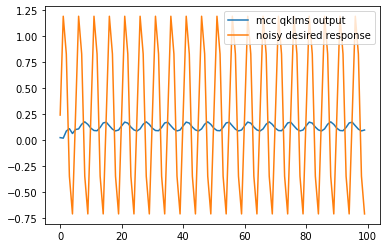

time: 110 ms (started: 2021-03-30 21:28:01 -04:00)


In [30]:
plt.plot(outputs_mcc[:100], label='mcc qklms output')
plt.plot(noisy_sine_2k[:100], label='noisy desired response')
plt.legend(loc='upper right')

#### 500 Hz input

In [31]:
qklms_mcc = MCC_QKLMS(step_size=step, sigma=sigma, order=10, epsilon=epsilon)
outputs_mcc, coefficients_mcc, errors_mcc, size_mcc = qklms_mcc.learn(sine_500, noisy_sine_2k)

time: 2.36 s (started: 2021-03-30 21:28:01 -04:00)


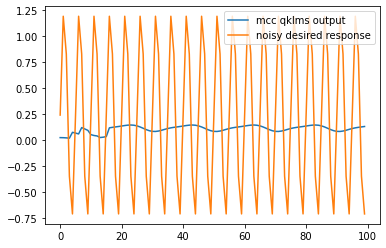

time: 110 ms (started: 2021-03-30 21:28:03 -04:00)


In [32]:
plt.plot(outputs_mcc[:100], label='mcc qklms output')
plt.plot(noisy_sine_2k[:100], label='noisy desired response')
plt.legend(loc='upper right')

### I don't know why my KLMS and QKLMS don't work. I've tried to perfect the algorithm since homework 3, and I'm wondering if I should have just adapted someone else's code rather than write my own. 